## Output intermediate swe calculation files:  
* Sample SWE Reanalysis clusters at station locations  
* Find nearest station to each grid cell
* Populate nearest station SNV and Quantile to each grid cell
* Populate mean cluster SNV and Quantile to each grid cell, with 3 cluster definitions
* Missing: Calculated CDF at each station and grid cell (see quantile_mapping_gridded.ipynb)  

In [4]:
import numpy as np 
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import pickle
import scipy.stats as stats
import os.path
from matplotlib.colors import LinearSegmentedColormap

In [3]:
xr?

Type:        module
String form: <module 'xarray' from '/opt/homebrew/Caskroom/miniforge/base/envs/cor_domains/lib/python3.13/site-packages/xarray/__init__.py'>
File:        /opt/homebrew/Caskroom/miniforge/base/envs/cor_domains/lib/python3.13/site-packages/xarray/__init__.py
Docstring:   <no docstring>

In [5]:
stations = pickle.load(open('../data/snv_dataframes/snv_temp_precip_cluster_gdf_snvs_quantiles.pkl','rb'))

/var/folders/s4/pymynk_14w75x2ghv0xjkqlm0000gn/T/ipykernel_42800/371455117.py:1: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  stations = pickle.load(open('../data/snv_dataframes/snv_temp_precip_cluster_gdf_snvs_quantiles.pkl','rb'))


In [6]:
stations

station_n  reanalysis_n  elevation_m  station_swe  \
station     year                                                      
301_CA_SNTL 1990  -0.492262     -0.194751  1886.712036     0.193040   
            1991  -0.806681      0.193222  1886.712036     0.142240   
            1992  -1.639892     -1.097426  1886.712036     0.007620   
            1993   0.938344     -0.578276  1886.712036     0.424180   
            1994  -0.335053     -0.422643  1886.712036     0.218440   
...                     ...           ...          ...          ...   
BLD         2017   0.619445      1.160298  2194.560000     1.033272   
            2018  -0.806206     -1.171988  2194.560000     0.371856   
            2019   0.501188      1.293572  2194.560000     0.978408   
            2020  -0.615681     -0.258835  2194.560000     0.460248   
            2021  -0.418586     -0.760679  2194.560000     0.551688   

                  station_swe_mean  reanalysis_swe  deg_days_0C  \
station     year                                                  
301_CA_SNTL 1990          0.272574          0.1718         57.0   
            1991          0.272574          0.2416         47.0   
            1992          0.272574          0.0094         64.0   
            1993          0.272574          0.1028         42.0   
            1994          0.272574          0.1308         48.0   
...                            ...             ...          ...   
BLD         2017          0.745887          1.1946         54.0   
            2018          0.745887          0.1796         82.0   
            2019          0.745887          1.2526         59.0   
            2020          0.745887          0.5770         68.0   
            2021          0.745887          0.3586         55.0   

                  cold_deg_days  cumulative_precip_m  precip_mean  ...  \
station     year                                                   ...   
301_CA_SNTL 1990            0.0             0.223842     0.332045  ...   
            1991            0.0             0.237158     0.332045  ...   
            1992            0.0             0.197154     0.332045  ...   
            1993            0.0             0.449491     0.332045  ...   
            1994            0.0             0.223718     0.332045  ...   
...                         ...                  ...          ...  ...   
BLD         2017            0.0             1.722192     0.846466  ...   
            2018            0.0             0.807857     0.846466  ...   
            2019            0.0             1.363057     0.846466  ...   
            2020            0.0             0.671916     0.846466  ...   
            2021            0.0             0.578816     0.846466  ...   

                  log_station_n  log_reanalysis_n   latitude   longitude  \
station     year                                                           
301_CA_SNTL 1990            NaN               NaN  41.235828 -120.791924   
            1991            NaN               NaN  41.235828 -120.791924   
            1992            NaN               NaN  41.235828 -120.791924   
            1993            NaN               NaN  41.235828 -120.791924   
            1994            NaN               NaN  41.235828 -120.791924   
...                         ...               ...        ...         ...   
BLD         2017       0.712421               NaN  38.451256 -120.034882   
            2018      -0.648226               NaN  38.451256 -120.034882   
            2019       0.639782               NaN  38.451256 -120.034882   
            2020      -0.364297               NaN  38.451256 -120.034882   
            2021      -0.123027               NaN  38.451256 -120.034882   

                                     geometry  cluster  \
station     year                                         
301_CA_SNTL 1990  POINT (-120.79192 41.23583)      3.0   
            1991  POINT (-120.79192 41.23583)      3.0   
            1992  POINT (-120.79192 41

In [84]:
stations[(stations.index.get_level_values(0)=='380_CO_SNTL') & (stations.index.get_level_values(1)==2020)]['station_swe']

station      year
380_CO_SNTL  2020    0.34544
Name: station_swe, dtype: float64

## Sample swe reanalysis clusters at station locations:

In [3]:
#clusters_ucrb_origres = xr.open_dataset('../data/ucrb_swe_reanalysis_3clusters_origres.nc').rio.write_crs('epsg:4326',inplace=True)
#clusters_wus_origres = xr.open_dataset('../data/swe_reanalysis_5clusters_highres.nc').rio.write_crs('epsg:4326',inplace=True)
clusters_wus_8xcoarse = xr.open_dataset('../data/swe_reanalysis_5clusters.nc').rio.write_crs('epsg:4326',inplace=True)

#clusters_ucrb_origres = clusters_ucrb_origres.__xarray_dataarray_variable__
#clusters_wus_origres = clusters_wus_origres.__xarray_dataarray_variable__
clusters_wus_8xcoarse = clusters_wus_8xcoarse.__xarray_dataarray_variable__

In [4]:
ucrb = pickle.load(open('../data/misc/ucrb.pkl','rb'))
stations_ucrb = stations.clip(ucrb)

In [5]:
stations_1yr = stations_ucrb[stations_ucrb.index.get_level_values(1)==1990]
stations_1yr = stations_1yr.reset_index(level=1, drop=True)

xs = stations_1yr.geometry.x.values
ys = stations_1yr.geometry.y.values

In [6]:
sampled_clusters_wus_8xcoarse = clusters_wus_8xcoarse.interp(x=xs, y=ys, method='nearest').values
#sampled_clusters_wus_origres = clusters_wus_origres.interp(x=xs, y=ys, method='nearest').values
#sampled_clusters_ucrb_origres = clusters_ucrb_origres.interp(x=xs, y=ys, method='nearest').values

In [7]:
stations_1yr['sampled_clusters_wus_8xcoarse'] = sampled_clusters_wus_8xcoarse.diagonal()
#stations_1yr['sampled_clusters_wus_origres'] = sampled_clusters_wus_origres.diagonal()
#stations_1yr['sampled_clusters_ucrb_origres'] = sampled_clusters_ucrb_origres.diagonal()

In [8]:
for site in stations_ucrb.index.get_level_values(0).unique():
    stations_ucrb.loc[(stations_ucrb.index.get_level_values(0)==site),'sampled_clusters_wus_8xcoarse'] = stations_1yr[stations_1yr.index == site]['sampled_clusters_wus_8xcoarse'].values[0]
    # stations_ucrb.loc[(stations_ucrb.index.get_level_values(0)==site),'sampled_clusters_wus_origres'] = stations_1yr[stations_1yr.index == site]['sampled_clusters_wus_origres'].values[0]
    # stations_ucrb.loc[(stations_ucrb.index.get_level_values(0)==site),'sampled_clusters_ucrb_origres'] = stations_1yr[stations_1yr.index == site]['sampled_clusters_ucrb_origres'].values[0]

/Users/Hannah/micromamba/envs/analysis_2024/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [72]:
stations_ucrb.to_pickle('../data/snv_dataframes/snv_ucrb_clusters_gdf_snvs_quantiles.pkl')

<Axes: >

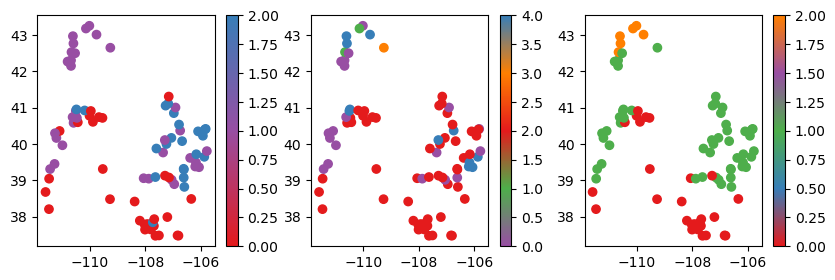

In [112]:
from matplotlib.colors import LinearSegmentedColormap
colors1=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00'] #,'#ffff33'
cmap1 = LinearSegmentedColormap.from_list('clusters', colors1)
colors2=['#984ea3','#4daf4a','#e41a1c','#ff7f00','#377eb8'] #,'#ffff33'
cmap2 = LinearSegmentedColormap.from_list('clusters', colors2)
colors3=['#e41a1c','#984ea3','#377eb8'] #,'#ffff33'
cmap3 = LinearSegmentedColormap.from_list('clusters', colors3)

fig, ax = plt.subplots(1,3, figsize=(10,3))
stations_1yr.plot(column = 'sampled_clusters_ucrb_origres', ax=ax[0], cmap = plt.get_cmap(cmap3, 6), legend=True)
stations_1yr.plot(column = 'sampled_clusters_wus_origres', ax=ax[1], cmap = plt.get_cmap(cmap2, 6), legend=True)
stations_1yr.plot(column = 'sampled_clusters_wus_8xcoarse', ax=ax[2], cmap = plt.get_cmap(cmap1, 6), legend=True)

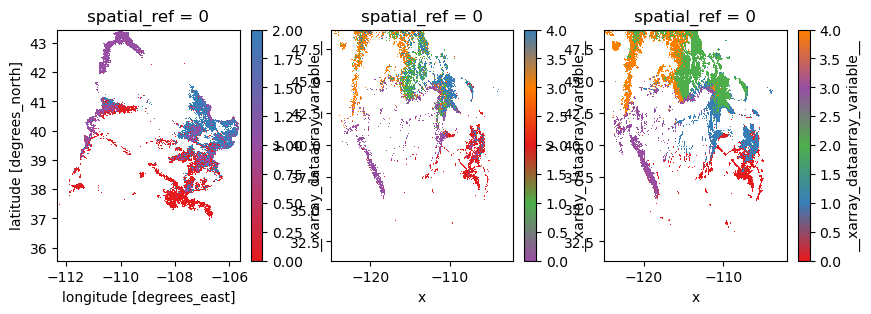

In [115]:
colors1=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00'] #,'#ffff33'
cmap1 = LinearSegmentedColormap.from_list('clusters', colors1)
colors2=['#984ea3','#4daf4a','#e41a1c','#ff7f00','#377eb8'] #,'#ffff33'
cmap2 = LinearSegmentedColormap.from_list('clusters', colors2)
colors3=['#e41a1c','#984ea3','#377eb8'] #,'#ffff33'
cmap3 = LinearSegmentedColormap.from_list('clusters', colors3)

fig, ax = plt.subplots(1,3, figsize=(10,3))
clusters_ucrb_origres.plot(ax=ax[0], cmap = plt.get_cmap(cmap3, 6))
clusters_wus_origres.plot(ax=ax[1], cmap = plt.get_cmap(cmap2, 6))
clusters_wus_8xcoarse.plot(ax=ax[2], cmap = plt.get_cmap(cmap1, 6))

#### Want to check silhouette scores for the high resolution clusters to see if 3 and 5 are still the right options.  
### Update: for original resolution data in the UCRB, 3 clusters seems like a fine choice. 

I did not convert the cluster numbers, so revisit this if I want to calculate cluster overlap between data sets.

_________
## Find the nearest station to each grid cell regardless of cluster:

In [45]:
nearest_station_nc_utm = xr.full_like(clusters_ucrb_origres.rio.reproject('epsg:32612'), np.nan)

#### And add an id column for numerical indexing:

In [33]:
stations_1yr['id'] = np.nan

In [34]:
for i in range(len(stations_1yr)):
    stations_1yr.loc[stations_1yr.index[i], 'id'] = i

#### Convert to UTM to compute distances:

In [46]:
stations_1yr_utm = stations_1yr.to_crs('epsg:32612')

In [ ]:
clusters_ucrb_origres_utm = clusters_ucrb_origres.rio.reproject('epsg:32612')

In [48]:
tree = cKDTree(np.c_[stations_1yr_utm.geometry.x.values,stations_1yr_utm.geometry.y.values])
indices = np.where(~np.isnan(clusters_ucrb_origres_utm))

# Extract coordinates from indices in data1
query_points = []
for i in range(len(indices[0])):
    y_index = indices[0][i]
    x_index = indices[1][i]
    x_coord = nearest_station_nc_utm.coords['x'].values[x_index]
    y_coord = nearest_station_nc_utm.coords['y'].values[y_index]
    query_points.append((x_coord, y_coord))
dist, idx = tree.query(query_points, k=1)
for i in np.arange(len(query_points)):
    nearest_station_nc_utm.loc[dict(x=query_points[i][0], y=query_points[i][1])] = stations_1yr_utm.iloc[idx[i]]['id']

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

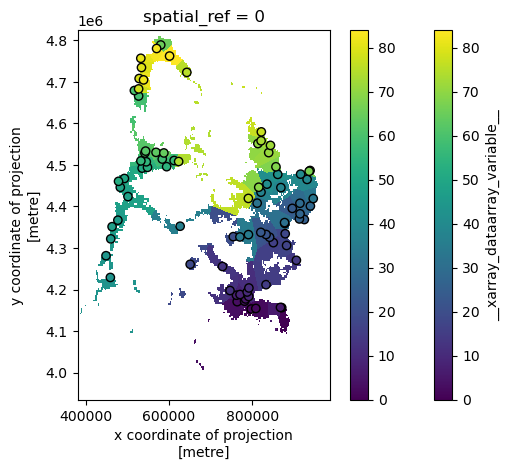

In [559]:
fig, ax = plt.subplots()
nearest_station_nc_utm.plot(ax=ax)
stations_1yr_utm.plot(ax=ax,column='id', edgecolor='k',legend=True)

In [50]:
nearest_station_nc_4326 = nearest_station_nc_utm.rio.reproject_match(clusters_ucrb_origres)

In [356]:
nearest_station_nc_4326.to_netcdf('../data/calculated_swe/intermediate_ncs/nearest_station.nc')

### Populate nearest station to each grid cell with SNV value, Quantile value, and station SWE:

#### SNV:

In [ ]:
nearest_snv_nc = xr.full_like(swe.SWE_Post, np.nan)

In [51]:
site_ids = list(np.unique(nearest_station_nc_4326.data))
site_ids_nan = site_ids[0:-1]

for i in site_ids_nan:
    for year in range(0,32):
        nearest_snv_nc[year] = nearest_snv_nc[year].where((nearest_station_nc_4326 != i), stations[(stations.index.get_level_values(1)==(year + 1990)) & (stations.index.get_level_values(0) == stations_1yr[stations_1yr['id']==i].index[0])]['station_n'].values[0])

In [357]:
nearest_snv_nc.to_netcdf('../data/calculated_swe/intermediate_ncs/nearest_station_snv_nc.nc')

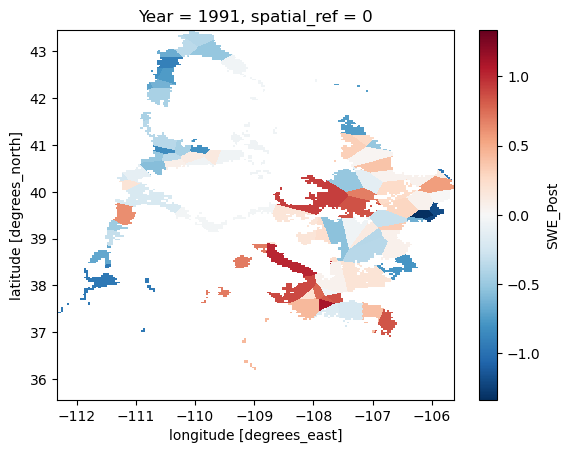

In [564]:
nearest_snv_nc[1].plot()

#### Quantiles:

In [62]:
nearest_station = xr.open_dataset('../data/calculated_swe/intermediate_ncs/nearest_station.nc')

In [64]:
file_path = '../data/calculated_swe/intermediate_ncs/nearest_station_quantile.nc'

if os.path.isfile(file_path):
    nearest_station_quantile = xr.open_dataarray(file_path)
else: 
    nearest_station = xr.open_dataset('../data/calculated_swe/intermediate_ncs/nearest_station.nc')
    nearest_station = nearest_station.__xarray_dataarray_variable__
    nearest_station_quantile = xr.full_like(swe.SWE_Post, np.nan)
    # populate this dataframe with that snotel's quantile data:
    site_ids = list(np.unique(nearest_station.data))
    site_ids_nan = site_ids[0:-1]
    
    for i in site_ids_nan:
        for year in range(0,32):
            nearest_station_quantile[year] = nearest_station_quantile[year].where((nearest_station != i), stations_ucrb[(stations_ucrb.index.get_level_values(1)==(year + 1990)) & (stations_ucrb.index.get_level_values(0) == stations_1yr[stations_1yr['id']==i].index[0])]['quantile_q8'].values[0])
    nearest_station_quantile.to_netcdf('../data/calculated_swe/intermediate_ncs/nearest_station_quantile.nc')    

### SWE Mapping from nearest station:

In [73]:
nearest_station = xr.open_dataset('../data/calculated_swe/intermediate_ncs/nearest_station.nc')

In [74]:
nearest_station = nearest_station.__xarray_dataarray_variable__

In [75]:
nearest_station_swe_mapping = xr.full_like(swe.SWE_Post, np.nan)

In [76]:
site_ids = list(np.unique(nearest_station.data))
site_ids_nan = site_ids[0:-1]

for i in site_ids_nan:
    for year in range(0,32):
        nearest_station_swe_mapping[year] = nearest_station_swe_mapping[year].where((nearest_station != i), stations_ucrb[(stations_ucrb.index.get_level_values(1)==(year + 1990)) & (stations_ucrb.index.get_level_values(0) == stations_1yr[stations_1yr['id']==i].index[0])]['station_swe'].values[0])

In [77]:
nearest_station_swe_mapping.to_netcdf('../data/calculated_swe/calculated_swe_nearest_swemapping.nc')

______
## Calculate the mean SNV and Quantile within each cluster for each year:

### Cluster definition: SWE Reanalysis WUS clusters at 8x coarsened:

### SNV:

In [9]:
swe = xr.open_dataset('../data/reanalysis/swe_reanalysis_ucrb.nc')

In [10]:
clusters_wus_8xcoarse_clip = clusters_wus_8xcoarse.rio.clip(ucrb.geometry)

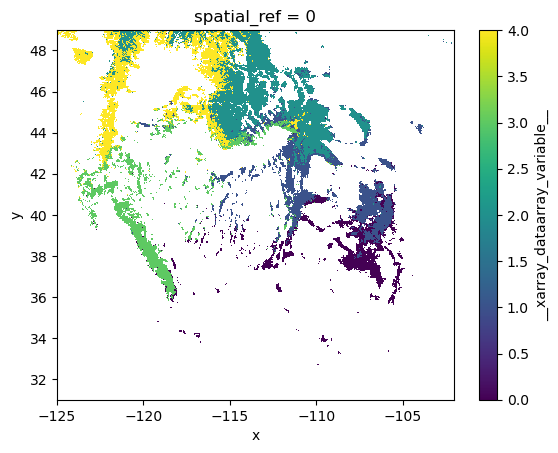

In [14]:
clusters_wus_8xcoarse.plot()

<Axes: >

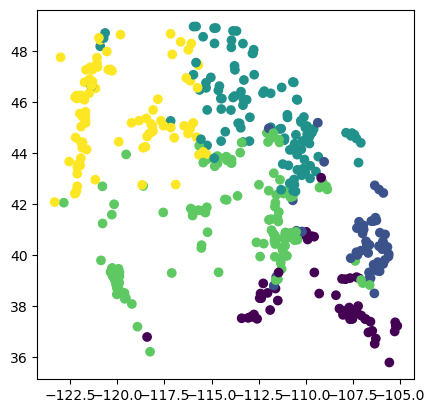

In [32]:
stations[stations.index.get_level_values(1)==1990].plot(column='cluster')

<Axes: >

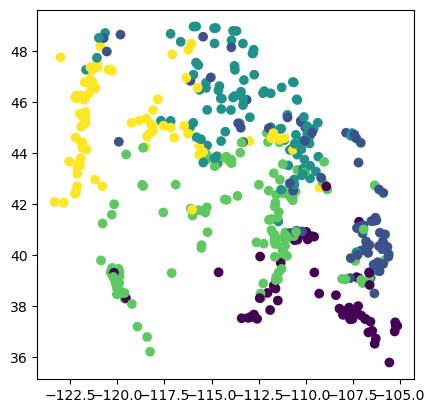

In [33]:
stations[stations.index.get_level_values(1)==1990].plot(column='reanalysis_cluster')

<Axes: >

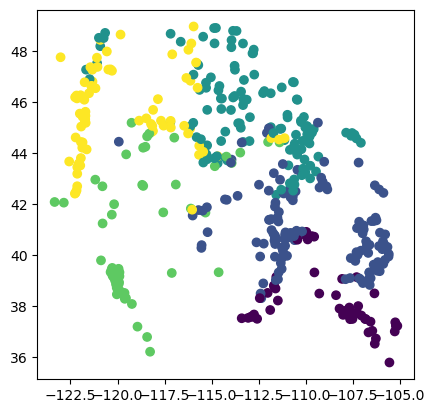

In [34]:
stations[stations.index.get_level_values(1)==1990].plot(column='sampled_reanalysis_cluster')

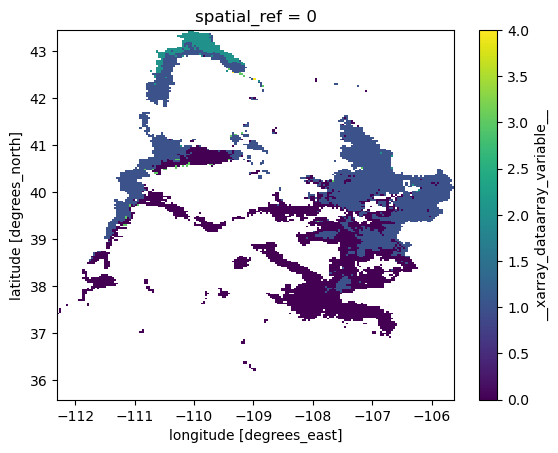

In [20]:
clusters_wus_8xcoarse_clip.plot()

In [11]:
clusters_wus_8xcoarse_match = clusters_wus_8xcoarse_clip.rio.reproject_match(swe.SWE_Post[0])

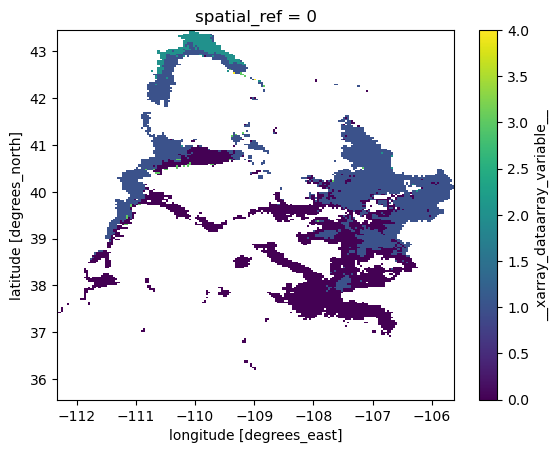

In [22]:
clusters_wus_8xcoarse_match.plot()

In [23]:
mean_snv_wus_coarse = xr.full_like(swe.SWE_Post, np.nan)

In [24]:
for year in np.arange(0,32):
    for cluster in stations_ucrb['sampled_clusters_wus_8xcoarse'].unique():
        mean_snv_wus_coarse[year] = mean_snv_wus_coarse[year].where(clusters_wus_8xcoarse_match != cluster, lambda x: stations_ucrb[(stations_ucrb.index.get_level_values(1) == (year+1990)) & (stations_ucrb['sampled_clusters_wus_8xcoarse']==cluster)]['station_n'].mean())

In [25]:
mean_snv_wus_coarse.to_netcdf('../data/calculated_swe/intermediate_ncs/mean_snv_wus_coarse_wic_sc.nc')

### Quantile: 

In [14]:
median_quantile_wus_coarse = xr.full_like(swe.SWE_Post, np.nan)

In [15]:
for year in np.arange(0,32):
    for cluster in stations_ucrb['sampled_clusters_wus_8xcoarse'].unique():
        median_quantile_wus_coarse[year] = median_quantile_wus_coarse[year].where(clusters_wus_8xcoarse_match != cluster, lambda x: stations_ucrb[(stations_ucrb.index.get_level_values(1) == (year+1990)) & (stations_ucrb['sampled_clusters_wus_8xcoarse']==cluster)]['quantile_q8'].median())

In [16]:
median_quantile_wus_coarse.to_netcdf('../data/calculated_swe/intermediate_ncs/median_quantile_wus_coarse_wic_sc.nc')

### Cluster definition: SWE Reanalysis WUS clusters at original resolution:

### SNV:

In [36]:
swe = xr.open_dataset('../data/reanalysis/swe_reanalysis_ucrb.nc')

In [45]:
clusters_wus_origres_match = clusters_wus_origres.rio.reproject_match(swe.SWE_Post[0])

In [46]:
mean_snv_wus_origres = xr.full_like(swe.SWE_Post, np.nan)

In [47]:
for year in np.arange(0,32):
    for cluster in stations_ucrb['sampled_clusters_wus_origres'].unique():
        mean_snv_wus_origres[year] = mean_snv_wus_origres[year].where(clusters_wus_origres_match != cluster, lambda x: stations_ucrb[(stations_ucrb.index.get_level_values(1) == (year+1990)) & (stations_ucrb['sampled_clusters_wus_origres']==cluster)]['station_n'].mean())

In [53]:
mean_snv_wus_origres.to_netcdf('../data/calculated_swe/intermediate_ncs/mean_snv_wus_origres_wic_sc.nc')

### Quantile: 

In [49]:
mean_quantile_wus_origres = xr.full_like(swe.SWE_Post, np.nan)

In [50]:
for year in np.arange(0,32):
    for cluster in stations_ucrb['sampled_clusters_wus_origres'].unique():
        mean_quantile_wus_origres[year] = mean_quantile_wus_origres[year].where(clusters_wus_origres_match != cluster, lambda x: stations_ucrb[(stations_ucrb.index.get_level_values(1) == (year+1990)) & (stations_ucrb['sampled_clusters_wus_origres']==cluster)]['quantile_q8'].mean())

In [54]:
mean_quantile_wus_origres.to_netcdf('../data/calculated_swe/intermediate_ncs/mean_quantile_wus_origres_wic_sc.nc')

### Cluster definition: SWE Reanalysis UCRB clusters at original resolution:

### SNV:

In [36]:
swe = xr.open_dataset('../data/reanalysis/swe_reanalysis_ucrb.nc')

In [55]:
clusters_ucrb_origres_match = clusters_ucrb_origres.rio.reproject_match(swe.SWE_Post[0])

In [56]:
mean_snv_ucrb_origres = xr.full_like(swe.SWE_Post, np.nan)

In [57]:
for year in np.arange(0,32):
    for cluster in stations_ucrb['sampled_clusters_ucrb_origres'].unique():
        mean_snv_ucrb_origres[year] = mean_snv_ucrb_origres[year].where(clusters_ucrb_origres_match != cluster, lambda x: stations_ucrb[(stations_ucrb.index.get_level_values(1) == (year+1990)) & (stations_ucrb['sampled_clusters_ucrb_origres']==cluster)]['station_n'].mean())

In [58]:
mean_snv_ucrb_origres.to_netcdf('../data/calculated_swe/intermediate_ncs/mean_snv_ucrb_origres_wic_sc.nc')

### Quantile: 

In [59]:
mean_quantile_ucrb_origres = xr.full_like(swe.SWE_Post, np.nan)

In [60]:
for year in np.arange(0,32):
    for cluster in stations_ucrb['sampled_clusters_ucrb_origres'].unique():
        mean_quantile_ucrb_origres[year] = mean_quantile_ucrb_origres[year].where(clusters_ucrb_origres_match != cluster, lambda x: stations_ucrb[(stations_ucrb.index.get_level_values(1) == (year+1990)) & (stations_ucrb['sampled_clusters_ucrb_origres']==cluster)]['quantile_q8'].mean())

In [61]:
mean_quantile_ucrb_origres.to_netcdf('../data/calculated_swe/intermediate_ncs/mean_quantile_ucrb_origres_wic_sc.nc')

______
## Calculate the mean SNV and Quantile within the entire UCRB for each year:

### SNV:

In [36]:
swe = xr.open_dataset('../data/reanalysis/swe_reanalysis_ucrb.nc')

In [65]:
mean_snv_ucrb_all = xr.full_like(swe.SWE_Post, np.nan)

In [67]:
for year in np.arange(0,32):
    mean_snv_ucrb_all[year] = stations_ucrb[(stations_ucrb.index.get_level_values(1) == (year+1990))]['station_n'].mean()

In [68]:
mean_snv_ucrb_all.to_netcdf('../data/calculated_swe/intermediate_ncs/mean_snv_ucrb_all.nc')

### Quantile: 

In [17]:
median_quantile_ucrb_all = xr.full_like(swe.SWE_Post, np.nan)

In [18]:
for year in np.arange(0,32):
    median_quantile_ucrb_all[year] = stations_ucrb[(stations_ucrb.index.get_level_values(1) == (year+1990))]['quantile_q8'].median()

In [19]:
median_quantile_ucrb_all.to_netcdf('../data/calculated_swe/intermediate_ncs/median_quantile_ucrb_all.nc')

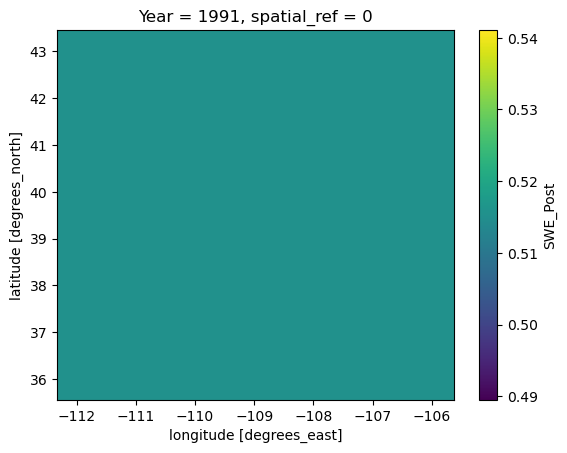

In [22]:
median_quantile_ucrb_all[1].plot()

_________
## (Am excluding this from my paper because of the overlap between within cluster nearest and nearest) Find the nearest WITHIN-CLUSTER station to each grid cell:

### Cluster definition: SWE Reanalysis WUS clusters at 8x coarsened:

In [93]:
clusters_wus_8xcoarse_match = clusters_wus_8xcoarse.rio.reproject_match(swe.SWE_Post[0])

In [45]:
nearest_station_wic_sc_utm = xr.full_like(clusters_wus_8xcoarse_match.rio.reproject('epsg:32612'), np.nan)

#### Make a dataframe with only one geometry per station:

#### Convert to UTM to compute distances:

In [52]:
nearest_station_utm = nearest_station.rio.reproject('epsg:32612')

In [53]:
clusters_wus_8xcoarse_match_utm = clusters_reanalysis_match.rio.reproject('epsg:32612')

#### We'll use scipy.spatial cKDTree for efficient distance metrics:

In [54]:
from scipy.spatial import cKDTree

In [56]:
for cluster in np.arange(0,4):
    
    tree = cKDTree(np.c_[stations_1yr_utm[stations_1yr_utm['sampled_clusters_wus_8xcoarse']==cluster].geometry.x.values,stations_1yr_utm[stations_1yr_utm['sampled_clusters_wus_8xcoarse']==cluster].geometry.y.values])
    indices = np.where(clusters_reanalysis_match_utm == cluster)

    # Extract coordinates from indices in data1
    query_points = []
    for i in range(len(indices[0])):
        y_index = indices[0][i]
        x_index = indices[1][i]
        x_coord = nearest_station.coords['x'].values[x_index]
        y_coord = nearest_station.coords['y'].values[y_index]
        query_points.append((x_coord, y_coord))
    dist, idx = tree.query(query_points, k=1)
    for i in np.arange(len(query_points)):
        nearest_station.loc[dict(x=query_points[i][0], y=query_points[i][1])] = stations_1yr[stations_1yr['cluster']==cluster].iloc[idx[i]]['id']

KeyboardInterrupt: 

In [ ]:
#nearest_station.to_netcdf('../data/calculated_swe/nearest_station_wic.nc')

#### SNV:

#### Quantile:

## Calculate Quantiles, Cluster on Quantiles:

In [ ]:
q_station = np.interp(stations[stations.index.get_level_values(0) == site]['station_swe'].values, station_ordered, quantiles)

In [18]:
swe = xr.open_dataset('../data/reanalysis/swe_reanalysis_ucrb.nc')

In [22]:
sr_quantiles_all

<xarray.DataArray 'SWE_Post' (quantile: 100, y: 1776, x: 1508)> Size: 1GB
[267820800 values with dtype=float32]
Coordinates:
  * y         (y) float64 14kB 35.56 35.57 35.57 35.58 ... 43.44 43.45 43.45
  * x         (x) float64 12kB -112.3 -112.3 -112.3 ... -105.6 -105.6 -105.6
  * quantile  (quantile) float64 800B 0.0 0.0101 0.0202 ... 0.9798 0.9899 1.0

In [74]:
file_path = '../data/calculated_swe/intermediate_ncs/swe_reanalysis_quantiles_for_clustering_q8.nc'

if os.path.isfile(file_path):
    swe_reanalysis_quantiles_for_clustering_q8 = xr.open_dataarray(file_path)
else:
    swe_reanalysis_quantiles_for_clustering_q8 = xr.full_like(swe.SWE_Post, np.nan)
    quantile_fn = '../data/quantile_ncs/sr_quantiles_allyears_q8.nc'
    sr_quantiles_all = xr.open_dataset(quantile_fn)
    for year in np.arange(0,32):        
        swe_reanalysis_quantiles_for_clustering_q8[year] = sr_quantiles_all.interp(quantile=swe.SWE_Post[year], method='linear')
    #swe_reanalysis_quantiles_for_clustering_q8.to_netcdf(file_path)

TypeError: cannot directly convert an xarray.Dataset into a numpy array. Instead, create an xarray.DataArray first, either with indexing on the Dataset or by invoking the `to_dataarray()` method.

In [165]:
sr_quantiles_all_reset = sr_quantiles_all.set_coords("SWE_Post")

#sr_quantiles_all_reset2 = sr_quantiles_all_reset.reset_coords("quantile")

In [197]:
sr_quantiles_all_drop = sr_quantiles_all.drop_indexes('quantile')
sr_quantiles_all_drop_var = sr_quantiles_all_drop.reset_coords('quantile')

In [200]:
sr_quantiles_all_drop_var

<xarray.Dataset> Size: 1GB
Dimensions:   (y: 1776, x: 1508, quantile: 100)
Coordinates:
  * y         (y) float64 14kB 35.56 35.57 35.57 35.58 ... 43.44 43.45 43.45
  * x         (x) float64 12kB -112.3 -112.3 -112.3 ... -105.6 -105.6 -105.6
Dimensions without coordinates: quantile
Data variables:
    quantile  (quantile) float64 800B 0.0 0.0101 0.0202 ... 0.9798 0.9899 1.0
    SWE_Post  (quantile, y, x) float32 1GB nan nan nan nan ... nan nan nan nan

In [169]:
sr_quantiles_all_reset

<xarray.Dataset> Size: 1GB
Dimensions:   (y: 1776, x: 1508, quantile: 100)
Coordinates:
  * y         (y) float64 14kB 35.56 35.57 35.57 35.58 ... 43.44 43.45 43.45
  * x         (x) float64 12kB -112.3 -112.3 -112.3 ... -105.6 -105.6 -105.6
  * quantile  (quantile) float64 800B 0.0 0.0101 0.0202 ... 0.9798 0.9899 1.0
    SWE_Post  (quantile, y, x) float32 1GB nan nan nan nan ... nan nan nan nan
Data variables:
    *empty*

In [172]:
sr_quantiles_all

<xarray.Dataset> Size: 1GB
Dimensions:   (y: 1776, x: 1508, quantile: 100)
Coordinates:
  * y         (y) float64 14kB 35.56 35.57 35.57 35.58 ... 43.44 43.45 43.45
  * x         (x) float64 12kB -112.3 -112.3 -112.3 ... -105.6 -105.6 -105.6
  * quantile  (quantile) float64 800B 0.0 0.0101 0.0202 ... 0.9798 0.9899 1.0
Data variables:
    SWE_Post  (quantile, y, x) float32 1GB nan nan nan nan ... nan nan nan nan

In [171]:
sr_quantiles_all_reset.isel(x=idx[0], y=idy[0]).interp(SWE_Post=0.5, method='linear')

ValueError: Dimensions {'SWE_Post'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'quantile': 100})

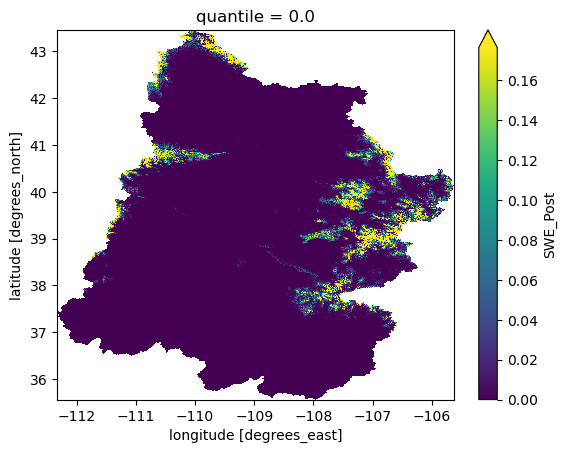

In [119]:
sr_quantiles_all.SWE_Post[0].plot(robust=True)

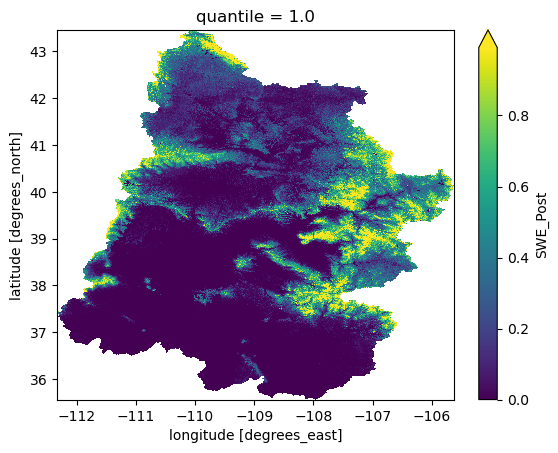

In [121]:
sr_quantiles_all.SWE_Post[99].plot(robust=True)

In [120]:
sr_quantiles_all

<xarray.Dataset> Size: 1GB
Dimensions:   (y: 1776, x: 1508, quantile: 100)
Coordinates:
  * y         (y) float64 14kB 35.56 35.57 35.57 35.58 ... 43.44 43.45 43.45
  * x         (x) float64 12kB -112.3 -112.3 -112.3 ... -105.6 -105.6 -105.6
  * quantile  (quantile) float64 800B 0.0 0.0101 0.0202 ... 0.9798 0.9899 1.0
Data variables:
    SWE_Post  (quantile, y, x) float32 1GB ...

In [75]:
sr_quantiles_all = xr.open_dataset(quantile_fn)

In [78]:
sr_quantiles_all.quantile

<bound method Dataset.quantile of <xarray.Dataset> Size: 1GB
Dimensions:   (y: 1776, x: 1508, quantile: 100)
Coordinates:
  * y         (y) float64 14kB 35.56 35.57 35.57 35.58 ... 43.44 43.45 43.45
  * x         (x) float64 12kB -112.3 -112.3 -112.3 ... -105.6 -105.6 -105.6
  * quantile  (quantile) float64 800B 0.0 0.0101 0.0202 ... 0.9798 0.9899 1.0
Data variables:
    SWE_Post  (quantile, y, x) float32 1GB ...>

In [89]:
test= sr_quantiles_all_reset.interp(SWE_Post=swe.SWE_Post[year], method='linear')

ValueError: Dimensions {'SWE_Post'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'y': 1776, 'x': 1508, 'quantile': 100})

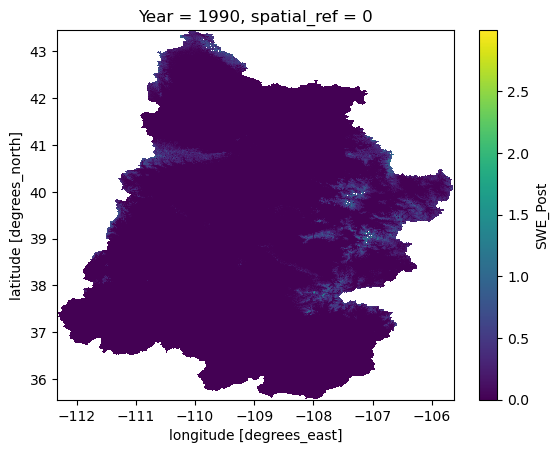

In [86]:
test.plot()

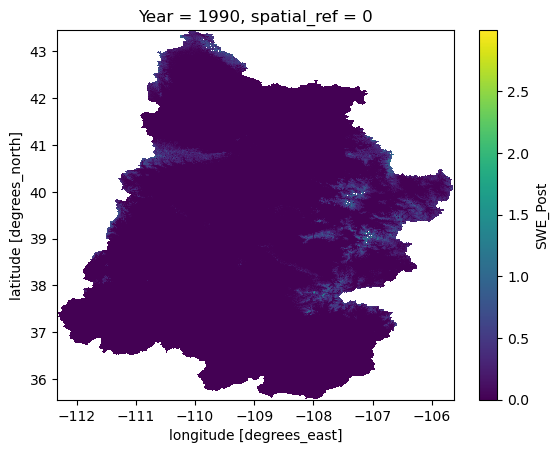

In [26]:
swe_reanalysis_quantiles_for_clustering_q8[0].plot()

### Closest to Butte station:

In [28]:
x1 = -106.95300293
y1 = 38.89432907

In [29]:
dist_y = np.sqrt((swe['y'].values - y1)**2) 
dist_x = np.sqrt((swe['x'].values - x1)**2)

In [30]:
idy = np.argwhere(dist_y == np.min(dist_y))[0]
idx = np.argwhere(dist_x == np.min(dist_x))[0]

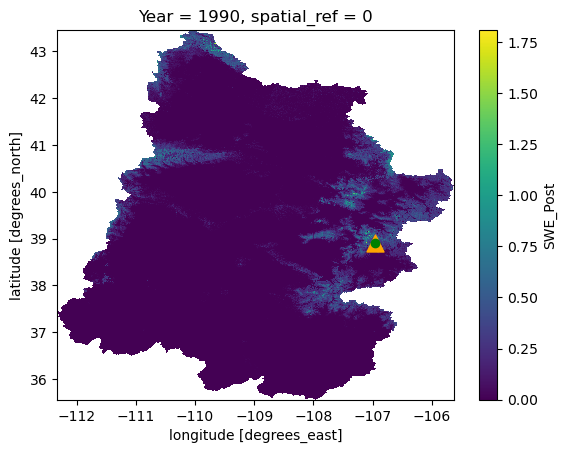

In [31]:
fig, ax = plt.subplots()
swe.SWE_Post[0].plot(ax=ax)
plt.scatter(x1,y1,marker = '^',s=150,color='orange')
plt.scatter(swe.x[idx[0]],swe.y[idy[0]],color='green')

In [47]:
swe_reanalysis_quantiles_for_clustering_q8.isel(x=idx[0], y=idy[0], Year=0).values

array(0.337098, dtype=float32)

In [49]:
swe.SWE_Post.isel(x=idx[0], y=idy[0], Year=0).values

array(0.3404, dtype=float32)

In [124]:
sr_quantiles_all

<xarray.Dataset> Size: 1GB
Dimensions:   (y: 1776, x: 1508, quantile: 100)
Coordinates:
  * y         (y) float64 14kB 35.56 35.57 35.57 35.58 ... 43.44 43.45 43.45
  * x         (x) float64 12kB -112.3 -112.3 -112.3 ... -105.6 -105.6 -105.6
  * quantile  (quantile) float64 800B 0.0 0.0101 0.0202 ... 0.9798 0.9899 1.0
Data variables:
    SWE_Post  (quantile, y, x) float32 1GB ...

In [145]:
swe.SWE_Post.isel(x=idx[0], y=idy[0])

<xarray.DataArray 'SWE_Post' (Year: 32)> Size: 128B
array([0.3404, 0.3146, 0.4616, 0.4048, 0.3202, 0.5866, 0.6206, 0.4586, 0.54  ,
       0.2956, 0.3976, 0.3874, 0.2568, 0.3626, 0.3176, 0.6902, 0.481 , 0.3354,
       0.441 , 0.5744, 0.46  , 0.5824, 0.2826, 0.2782, 0.6186, 0.3064, 0.467 ,
       0.5952, 0.2916, 0.6716, 0.4032, 0.1408], dtype=float32)
Coordinates:
    y            float64 8B 38.9
    x            float64 8B -107.0
  * Year         (Year) int64 256B 1990 1991 1992 1993 ... 2018 2019 2020 2021
    spatial_ref  int64 8B ...
Attributes:
    Units:    meters

In [163]:
sr_quantiles_all.isel(x=idx[0], y=idy[0]).where(sr_quantiles_all.isel(x=idx[0], y=idy[0]).quantile==0.17712323)

<xarray.Dataset> Size: 1kB
Dimensions:   (quantile: 100)
Coordinates:
    y         float64 8B 38.9
    x         float64 8B -107.0
  * quantile  (quantile) float64 800B 0.0 0.0101 0.0202 ... 0.9798 0.9899 1.0
Data variables:
    SWE_Post  (quantile) float32 400B nan nan nan nan nan ... nan nan nan nan

In [164]:
sr_quantiles_all.isel(x=idx[0], y=idy[0]).where(sr_quantiles_all.SWE_Post==0.3)

<xarray.Dataset> Size: 1GB
Dimensions:   (quantile: 100, y: 1776, x: 1508)
Coordinates:
  * y         (y) float64 14kB 35.56 35.57 35.57 35.58 ... 43.44 43.45 43.45
  * x         (x) float64 12kB -112.3 -112.3 -112.3 ... -105.6 -105.6 -105.6
  * quantile  (quantile) float64 800B 0.0 0.0101 0.0202 ... 0.9798 0.9899 1.0
Data variables:
    SWE_Post  (quantile, y, x) float32 1GB nan nan nan nan ... nan nan nan nan

In [158]:
sr_quantiles_all.isel(x=idx[0], y=idy[0]).interp(quantile=0.17712323, method='linear')
#sr_quantiles_all.isel(x=idx[0], y=idy[0]).interp(quantile=swe.SWE_Post.isel(x=idx[0], y=idy[0], Year=0), method='linear')

<xarray.Dataset> Size: 32B
Dimensions:   ()
Coordinates:
    y         float64 8B 38.9
    x         float64 8B -107.0
    quantile  float64 8B 0.1771
Data variables:
    SWE_Post  float64 8B 0.2966

In [156]:
sr_quantiles_all.SWE_Post.isel(x=idx[0], y=idy[0]).values

array([0.1408    , 0.1408    , 0.1408    , 0.17712323, 0.21500875,
       0.25289428, 0.26306868, 0.27005792, 0.27704713, 0.2794    ,
       0.28083703, 0.28227407, 0.2848727 , 0.2878121 , 0.29075152,
       0.29252928, 0.29383567, 0.29514208, 0.2978909 , 0.3014182 ,
       0.30494547, 0.30797374, 0.31065184, 0.31332996, 0.31511515,
       0.31609496, 0.31707475, 0.31799394, 0.3188431 , 0.31969225,
       0.32219595, 0.32716027, 0.33212456, 0.33595553, 0.33758855,
       0.33922157, 0.3424182 , 0.34966868, 0.3569192 , 0.36435354,
       0.3724532 , 0.38055286, 0.38791516, 0.39124647, 0.39457777,
       0.3977697 , 0.39959866, 0.4014276 , 0.40321615, 0.4037387 ,
       0.4042613 , 0.40478384, 0.41625723, 0.42808014, 0.43990305,
       0.44621482, 0.45196298, 0.45771113, 0.45898655, 0.45944378,
       0.459901  , 0.46040943, 0.460932  , 0.46145454, 0.46287274,
       0.46463636, 0.4664    , 0.47001684, 0.47458923, 0.47916162,
       0.49252188, 0.5117913 , 0.53106064, 0.5460229 , 0.55725

In [ ]:
sr_quantiles_all.

In [157]:
sr_quantiles_all.isel(x=idx[0], y=idy[0])

<xarray.Dataset> Size: 1kB
Dimensions:   (quantile: 100)
Coordinates:
    y         float64 8B 38.9
    x         float64 8B -107.0
  * quantile  (quantile) float64 800B 0.0 0.0101 0.0202 ... 0.9798 0.9899 1.0
Data variables:
    SWE_Post  (quantile) float32 400B ...

In [133]:
sr_quantiles_all.isel(x=idx[0], y=idy[0]).interp(quantile=swe.SWE_Post.isel(x=idx[0], y=idy[0], Year=15), method='linear')

<xarray.Dataset> Size: 44B
Dimensions:      ()
Coordinates:
    y            float64 8B 38.9
    x            float64 8B -107.0
    quantile     float32 4B 0.6902
    Year         int64 8B 2005
    spatial_ref  int64 8B ...
Data variables:
    SWE_Post     float64 8B 0.4761

In [138]:
sr_quantiles_all.SWE_Post[0:]

<xarray.DataArray 'SWE_Post' (quantile: 100, y: 1776, x: 1508)> Size: 1GB
[267820800 values with dtype=float32]
Coordinates:
  * y         (y) float64 14kB 35.56 35.57 35.57 35.58 ... 43.44 43.45 43.45
  * x         (x) float64 12kB -112.3 -112.3 -112.3 ... -105.6 -105.6 -105.6
  * quantile  (quantile) float64 800B 0.0 0.0101 0.0202 ... 0.9798 0.9899 1.0

In [136]:
sr_quantiles_all.sel(quantile=0.99)

KeyError: "not all values found in index 'quantile'. Try setting the `method` keyword argument (example: method='nearest')."

In [140]:
swe.SWE_Post.isel(x=idx[0], y=idy[0]).max()

<xarray.DataArray 'SWE_Post' ()> Size: 8B
array(0.69019997)
Coordinates:
    y            float64 8B 38.9
    x            float64 8B -107.0
    spatial_ref  int64 8B ...

In [189]:
swe_ex = swe.SWE_Post.isel(x=idx[0], y=idy[0]).values

In [190]:
swe_ex

array([0.3404, 0.3146, 0.4616, 0.4048, 0.3202, 0.5866, 0.6206, 0.4586,
       0.54  , 0.2956, 0.3976, 0.3874, 0.2568, 0.3626, 0.3176, 0.6902,
       0.481 , 0.3354, 0.441 , 0.5744, 0.46  , 0.5824, 0.2826, 0.2782,
       0.6186, 0.3064, 0.467 , 0.5952, 0.2916, 0.6716, 0.4032, 0.1408],
      dtype=float32)

In [177]:
quantile_ex = sr_quantiles_all.SWE_Post.isel(x=idx[0], y=idy[0]).values

In [178]:
quantile_ex

array([0.1408    , 0.1408    , 0.1408    , 0.17712323, 0.21500875,
       0.25289428, 0.26306868, 0.27005792, 0.27704713, 0.2794    ,
       0.28083703, 0.28227407, 0.2848727 , 0.2878121 , 0.29075152,
       0.29252928, 0.29383567, 0.29514208, 0.2978909 , 0.3014182 ,
       0.30494547, 0.30797374, 0.31065184, 0.31332996, 0.31511515,
       0.31609496, 0.31707475, 0.31799394, 0.3188431 , 0.31969225,
       0.32219595, 0.32716027, 0.33212456, 0.33595553, 0.33758855,
       0.33922157, 0.3424182 , 0.34966868, 0.3569192 , 0.36435354,
       0.3724532 , 0.38055286, 0.38791516, 0.39124647, 0.39457777,
       0.3977697 , 0.39959866, 0.4014276 , 0.40321615, 0.4037387 ,
       0.4042613 , 0.40478384, 0.41625723, 0.42808014, 0.43990305,
       0.44621482, 0.45196298, 0.45771113, 0.45898655, 0.45944378,
       0.459901  , 0.46040943, 0.460932  , 0.46145454, 0.46287274,
       0.46463636, 0.4664    , 0.47001684, 0.47458923, 0.47916162,
       0.49252188, 0.5117913 , 0.53106064, 0.5460229 , 0.55725

In [191]:
dist_arr = (quantile_ex - swe_ex)**2

ValueError: operands could not be broadcast together with shapes (100,) (32,) 

In [185]:
dist_arr

array([1.53664057e-03, 1.53664057e-03, 1.53664057e-03, 8.27582608e-06,
       1.22561213e-03, 5.31357527e-03, 6.90040365e-03, 8.11042730e-03,
       9.41814389e-03, 9.88035649e-03, 1.01681054e-02, 1.04599837e-02,
       1.09982835e-02, 1.16234506e-02, 1.22658974e-02, 1.26628382e-02,
       1.29585583e-02, 1.32576982e-02, 1.38982628e-02, 1.47423744e-02,
       1.56113682e-02, 1.63772777e-02, 1.70699004e-02, 1.77768786e-02,
       1.82561036e-02, 1.85218379e-02, 1.87894832e-02, 1.90423243e-02,
       1.92774031e-02, 1.95139237e-02, 2.02196855e-02, 2.16561425e-02,
       2.31418796e-02, 2.43221261e-02, 2.48341486e-02, 2.53515057e-02,
       2.63796672e-02, 2.87874583e-02, 3.13003995e-02, 3.39862257e-02,
       3.70382369e-02, 4.02214453e-02, 4.32287119e-02, 4.46250662e-02,
       4.60436158e-02, 4.74236347e-02, 4.82235663e-02, 4.90301773e-02,
       4.98254485e-02, 5.00590056e-02, 5.02931252e-02, 5.05277738e-02,
       5.58174774e-02, 6.15437515e-02, 6.75495937e-02, 7.08703324e-02,
      

In [186]:
np.argmin(dist_arr)

3

In [192]:
sr_quantiles_all.indexes

Indexes:
    y         Index([35.562252044677734,  35.56669616699219,  35.57114028930664,
       35.575584411621094,  35.58002853393555,     35.58447265625,
        35.58891677856445, 35.593360900878906,  35.59780502319336,
        35.60224914550781,
       ...
        43.41115188598633,  43.41559600830078, 43.420040130615234,
        43.42448425292969,  43.42892837524414, 43.433372497558594,
        43.43781661987305,   43.4422607421875,  43.44670486450195,
       43.451148986816406],
      dtype='float64', name='y', length=1776)
    x         Index([-112.32614135742188, -112.32169342041016, -112.31724548339844,
       -112.31279754638672,   -112.308349609375, -112.30390167236328,
       -112.29945373535156, -112.29500579833984, -112.29055786132812,
        -112.2861099243164,
       ...
       -105.66863250732422,  -105.6641845703125, -105.65973663330078,
       -105.65528869628906, -105.65084075927734, -105.64639282226562,
        -105.6419448852539, -105.63749694824219, -105.633049

In [ ]:
idx = sr_quantiles_all.indexes["time"].get_loc('2013-06-01 00:00:00',  method="nearest")
print(idx)

In [187]:
sr_quantiles_all.isel(x=idx[0], y=idy[0], quantile=3)

<xarray.Dataset> Size: 28B
Dimensions:   ()
Coordinates:
    y         float64 8B 38.9
    x         float64 8B -107.0
    quantile  float64 8B 0.0303
Data variables:
    SWE_Post  float32 4B 0.1771

In [188]:
sr_quantiles_all

<xarray.Dataset> Size: 1GB
Dimensions:   (y: 1776, x: 1508, quantile: 100)
Coordinates:
  * y         (y) float64 14kB 35.56 35.57 35.57 35.58 ... 43.44 43.45 43.45
  * x         (x) float64 12kB -112.3 -112.3 -112.3 ... -105.6 -105.6 -105.6
  * quantile  (quantile) float64 800B 0.0 0.0101 0.0202 ... 0.9798 0.9899 1.0
Data variables:
    SWE_Post  (quantile, y, x) float32 1GB nan nan nan nan ... nan nan nan nan

In [ ]:
def sm_intersect(xlat,xlon,obs_lat,obs_lon):
    """
    Intersects lat and lon location of insitu observation with SnowModel grid
    Input:
      xlat - 2D numpy array representing latitude values for each SnowModel grid
                      point.
      xlon - 2D numpy array representing latitude values for each SnowModel grid
                      point.
      obs_lat - python float of latitude for observation.
      obs_lon - python float of longitude for observation.
    Output:
      idy - integer representing y-index of intersected point on SnowModel grid.
      idx - integer representing x-index of intersected point on SnowModel grid.
    """
    dist = np.sqrt((xlat - obs_lat)**2 + (xlon - obs_lon)**2)
    idy,idx = np.argwhere(dist == np.min(dist))[0]
    return idy,idx

In [193]:
sr_quantiles_all

<xarray.Dataset> Size: 1GB
Dimensions:   (y: 1776, x: 1508, quantile: 100)
Coordinates:
  * y         (y) float64 14kB 35.56 35.57 35.57 35.58 ... 43.44 43.45 43.45
  * x         (x) float64 12kB -112.3 -112.3 -112.3 ... -105.6 -105.6 -105.6
  * quantile  (quantile) float64 800B 0.0 0.0101 0.0202 ... 0.9798 0.9899 1.0
Data variables:
    SWE_Post  (quantile, y, x) float32 1GB nan nan nan nan ... nan nan nan nan

In [195]:
sr_quantiles_all.drop_indexes('quantile')

<xarray.Dataset> Size: 1GB
Dimensions:   (y: 1776, x: 1508, quantile: 100)
Coordinates:
  * y         (y) float64 14kB 35.56 35.57 35.57 35.58 ... 43.44 43.45 43.45
  * x         (x) float64 12kB -112.3 -112.3 -112.3 ... -105.6 -105.6 -105.6
    quantile  (quantile) float64 800B 0.0 0.0101 0.0202 ... 0.9798 0.9899 1.0
Data variables:
    SWE_Post  (quantile, y, x) float32 1GB nan nan nan nan ... nan nan nan nan

In [173]:
sr_quantiles_all.SWE_Post.isel(x=idx[0], y=idy[0])

<xarray.DataArray 'SWE_Post' (quantile: 100)> Size: 400B
array([0.1408  , 0.1408  , 0.1408  , 0.177123, 0.215009, 0.252894, 0.263069,
       0.270058, 0.277047, 0.2794  , 0.280837, 0.282274, 0.284873, 0.287812,
       0.290752, 0.292529, 0.293836, 0.295142, 0.297891, 0.301418, 0.304945,
       0.307974, 0.310652, 0.31333 , 0.315115, 0.316095, 0.317075, 0.317994,
       0.318843, 0.319692, 0.322196, 0.32716 , 0.332125, 0.335956, 0.337589,
       0.339222, 0.342418, 0.349669, 0.356919, 0.364354, 0.372453, 0.380553,
       0.387915, 0.391246, 0.394578, 0.39777 , 0.399599, 0.401428, 0.403216,
       0.403739, 0.404261, 0.404784, 0.416257, 0.42808 , 0.439903, 0.446215,
       0.451963, 0.457711, 0.458987, 0.459444, 0.459901, 0.460409, 0.460932,
       0.461455, 0.462873, 0.464636, 0.4664  , 0.470017, 0.474589, 0.479162,
       0.492522, 0.511791, 0.531061, 0.546023, 0.557258, 0.568493, 0.575639,
       0.578252, 0.580865, 0.582966, 0.584337, 0.585709, 0.587584, 0.590393,
       0.593202, 0.597406, 0.605048, 0.612691, 0.618748, 0.619401, 0.620055,
       0.623347, 0.640004, 0.656661, 0.672226, 0.678301, 0.684376, 0.6902  ,
       0.6902  , 0.6902  ], dtype=float32)
Coordinates:
    y         float64 8B 38.9
    x         float64 8B -107.0
  * quantile  (quantile) float64 800B 0.0 0.0101 0.0202 ... 0.9798 0.9899 1.0

In [128]:
swe_reanalysis_quantiles_for_clustering_q8

<xarray.DataArray 'SWE_Post' (Year: 32, y: 1776, x: 1508)> Size: 343MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * y            (y) float64 14kB 35.56 35.57 35.57 35.58 ... 43.44 43.45 43.45
  * x            (x) float64 12kB -112.3 -112.3 -112.3 ... -105.6 -105.6 -105.6
  * Year         (Year) int64 256B 1990 1991 1992 1993 ... 2018 2019 2020 2021
    spatial_ref  int64 8B ...
Attributes:
    Units:    meters

In [130]:
swe_reanalysis_quantiles_for_clustering_q8.isel(x=idx[0], y=idy[0], Year=0).values

array(nan, dtype=float32)

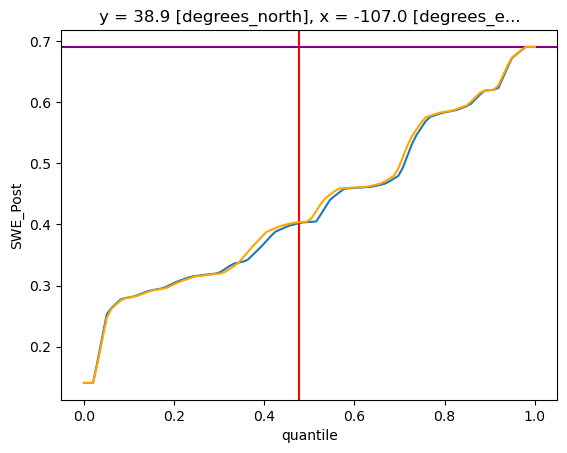

In [135]:
plt.subplots()
sr_quantiles_all.SWE_Post.isel(x=idx[0], y=idy[0]).plot()
plt.axvline(0.4761, c='r')
plt.axhline(swe.SWE_Post.isel(x=idx[0], y=idy[0], Year=15).values, c='purple')
#plt.plot(quantiles,butte_cdf, label = 'Butte CDF', color='purple')
swe_quantile_1990.SWE_Post.isel(x=idx[0], y=idy[0]).plot(color='orange')

This plot causes me to trust the sr_quantiles_all, because it matches well with my previously calculated cuantiles for the swe reanalysis dataset. So my interpolating of the swe on the quantiles xarray is wrong though.

In [62]:
swe_quantile_1990 = xr.open_dataset('../data/quantile_ncs/sr_quantiles_1990_q8.nc')

In [59]:
site1 = '380_CO_SNTL' # Butte station
site2 = '737_CO_SNTL' # Schofield Pass station

quantiles = np.linspace(0,1,100)

year = 2020
schofield_q = stations.loc[(stations.index.get_level_values(0)==site2) & (stations.index.get_level_values(1)==year)]['quantile_q8'].values[0]
schofield_swe = stations.loc[(stations.index.get_level_values(0)==site2) & (stations.index.get_level_values(1)==year)]['station_swe'].values[0]
butte_cdf = np.quantile(stations.loc[(stations.index.get_level_values(1) != year) & (stations.index.get_level_values(0) == site1)]['station_swe'], quantiles, method='median_unbiased')
schofield_cdf = np.quantile(stations.loc[(stations.index.get_level_values(1) != year) & (stations.index.get_level_values(0) == site2)]['station_swe'], quantiles, method='median_unbiased')
butte_quantile_1990 = np.interp(schofield_q, quantiles, np.sort(butte_cdf))

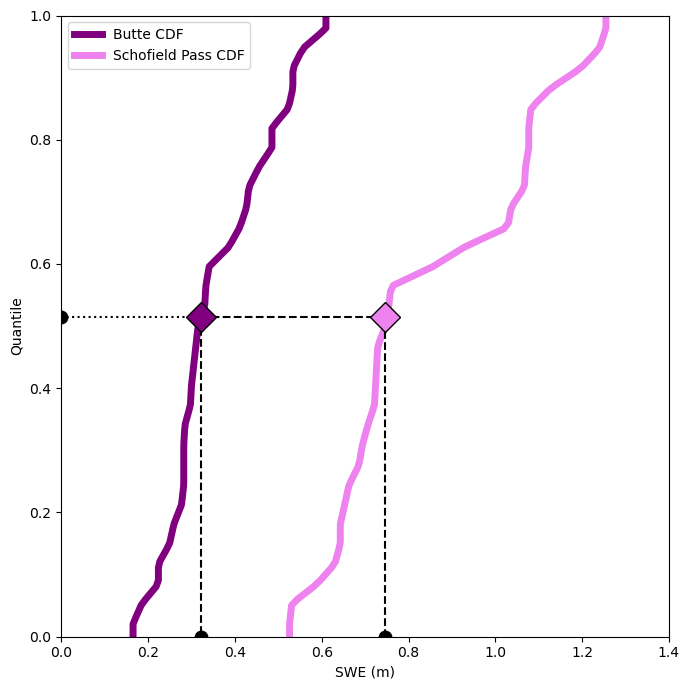

In [60]:
quantiles = np.linspace(0,1,100)


plt.figure(figsize=(7,7))

plt.plot(butte_cdf, quantiles, label = 'Butte CDF', color='purple', linewidth=5)
plt.plot(schofield_cdf, quantiles, label = 'Schofield Pass CDF', color='violet', linewidth=5)

# Plot a line from the x-axis to the Schofield Pass test point
plt.plot([schofield_swe, schofield_swe], [0, schofield_q], c='k', linestyle='--')
# Plot a line from the test point to the y-axis
plt.plot([schofield_swe, butte_quantile_1990], [schofield_q, schofield_q], c='k', linestyle='--')
# Plot a line from the test point to the y-axis
plt.plot([0, butte_quantile_1990], [schofield_q, schofield_q], c='k', linestyle=':')
# Plot a line from the Butte test point to the x-axis
plt.plot([butte_quantile_1990, butte_quantile_1990], [schofield_q, 0], c='k', linestyle='--')

# Plot a marker at the location of the 'current-year' quantile on the Schofield CDF
plt.plot(schofield_swe, schofield_q, 'D', markerfacecolor='violet', markeredgecolor='k',markersize=15)
# Plot a marker at the location of the 'current-year' quantile on the Butte CDF
plt.plot(butte_quantile_1990, schofield_q, 'D', markerfacecolor='purple', markeredgecolor='k',markersize=15)

# Plot a marker on the x-axis that corresponds to the Schofield Pass SWE at the 'current-year' quantile
plt.plot(schofield_swe, 0, 'o', markerfacecolor='k', markeredgecolor='none',markersize=10)
# Plot a marker on the x-axis that corresponds to the Butte SWE at the 'current-year' Schofield Pass quantile
plt.plot(butte_quantile_1990, 0, 'o', markerfacecolor='k', markeredgecolor='none',markersize=10)
# Plot a marker on the y-axis that corresponds to the 'current-year' Schofield Pass quantile
plt.plot(0, schofield_q, 'o', markerfacecolor='k', markeredgecolor='none',markersize=10)

plt.legend()
plt.xlabel('SWE (m)')
plt.ylabel('Quantile')
plt.ylim(0,1)
plt.xlim(0,1.4)

plt.tight_layout()

In [15]:
year=0
quantile_fn = f'../data/quantile_ncs/sr_quantiles_{year+1990}_q8.nc'
sr_quantiles_yr = xr.open_dataarray(quantile_fn)

In [16]:
sr_quantiles_yr

<xarray.DataArray 'SWE_Post' (quantile: 100, y: 1776, x: 1508)> Size: 1GB
[267820800 values with dtype=float32]
Coordinates:
  * y         (y) float64 14kB 35.56 35.57 35.57 35.58 ... 43.44 43.45 43.45
  * x         (x) float64 12kB -112.3 -112.3 -112.3 ... -105.6 -105.6 -105.6
  * quantile  (quantile) float64 800B 0.0 0.0101 0.0202 ... 0.9798 0.9899 1.0